###  Cauchy 1D Inference Problem

Solve: $$y''(t) + 2y'(t) + y(t) = e^{-t}cos(2t)$$
For $t>0$ and with initial conditions:
$$y(0) = 1, \; y'(0) = -1$$
The exact solution is $$y(t) = -\frac{1}{4} e^{-t} (cos(2  t) - 5)$$

***

We will assume $t \in [0,10]$.<br>
$N_u = 1$ our training data ($y(0) = 1 , y'(0) = -1$) and $N_f = 10000$ our collocations points ($t_i \in [0,10]$ for $i=0,1,...,9999$). <br>
NN input is $t$, size 1. <br>
NN output is $y(t)$, size 1. <br>
We will use 9 hidden layers with 20 nodes and tanh as activation function.<br>  
For regularization define: $f = y''(t) + 2y'(t) + y(t) - e^{-t}cos(2t)$

### Data Generation

In [19]:
import numpy as np

def exact_y(t):
    return -1.0/4 * np.exp(-t)*(np.cos(2*t)-5)

def exact_y_t(t):
    return 1.0/4 * np.exp(-t) * (2*np.sin(2*t)+np.cos(2*t)-5)

def exact_y_tt(t):
    return 1.0/4 * np.exp(-t) * (-4*np.sin(2*t) + 3*np.cos(2*t)+5)

def exact_de(t): #membre de droite equadiff
    return np.exp(-t)*np.cos(2*t)

# generate colocation points
import random
random.seed(1)

upper_bound = 15
lower_bound = 0

N_f = 100
t_f = [random.uniform(lower_bound,upper_bound) for _ in range(N_f)] # a list
t_f = np.array([t_f]).T  #an array

y_f = exact_y(t_f).reshape(-1,1) #exact y(t)
y_t_f = exact_y_t(t_f).reshape(-1,1) #exact y'(t)
y_tt_f = exact_y_tt(t_f).reshape(-1,1) #exact y''(t)
de_f = exact_de(t_f) #exact membre de droit de l'equa diff

N_u = 1
t_u = np.array([0.0]).reshape(-1,1)
y_u = 1
y_t_u = -1



### PINN Architecture

In [25]:
import torch
from torch import nn 

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() 

        self.fc1 = nn.Linear(1, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 20)
        self.fc4 = nn.Linear(20, 20)
        self.fc5 = nn.Linear(20, 20)
        self.fc6 = nn.Linear(20, 20)
        self.fc7 = nn.Linear(20, 20)
        self.fc8 = nn.Linear(20, 20)
        self.fc9 = nn.Linear(20, 1)
        
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        x = torch.tanh(self.fc5(x))
        x = torch.tanh(self.fc6(x))
        x = torch.tanh(self.fc7(x))
        x = torch.tanh(self.fc8(x))
        x = torch.tanh(self.fc9(x))
        return x


"""net = Net()
print(net)

params = list(net.parameters())
#print(len(params))
for par in params:
    print(par.shape)"""
    

'net = Net()\nprint(net)\n\nparams = list(net.parameters())\n#print(len(params))\nfor par in params:\n    print(par.shape)'

### PINN train and loss definition

In [68]:
import torch.optim as optim
import numpy as np

class PINN():
    def __init__(self, t_u, y_u, y_t_u, t_f, max_iter=1000):
        
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print(f"device used: {self.device}")
        
        self.t_u = torch.tensor(t_u, requires_grad=True).float().to(self.device) # t=0
        self.y_u = torch.tensor(y_u).float().to(self.device) # y(0) = 1
        self.y_t_u = torch.tensor(y_t_u).float().to(self.device) #y(0) = -1
        self.t_f = torch.tensor(t_f, requires_grad=True).float().to(self.device)
        
        
        
        self.net = Net().to(self.device)
        
        self.optimizer = optim.Adam(self.net.parameters())
        
        self.max_iter = max_iter
        
        '''
        self.optimizer = torch.optim.LBFGS(
            self.net.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=100,  #very important
            tolerance_grad=1e-7, #1e-8
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"    
        )
        '''

        self.iter = 1
        
    def net_y_y_t(self,t): #get y(t) for a t; a forward pass through the PINN
        y = self.net(t)
        y_t = torch.autograd.grad( #first partial derivative with respect to t
            y, t, 
            grad_outputs=torch.ones_like(y),
            retain_graph=True,
            create_graph=True
        )[0]
        return y, y_t

    

    
    def net_f(self, t): #get f = y_ttt + 2 * y_tt + y_t - exp(-t)cos(2t)
        
        y, y_t = self.net_y_y_t(t)
        
        y_tt = torch.autograd.grad( #second partial derivative with respect to t
            y_t, t, 
            grad_outputs=torch.ones_like(y_t),
            retain_graph=True,
            create_graph=True
        )[0]
        f = y_tt + 2 * y_t + y - torch.exp(-t) * torch.cos(2 * t)
        return f

    def loss_func(self):
        self.optimizer.zero_grad()
        
        y_pred, y_t_pred = self.net_y_y_t(self.t_u) 
        f_pred = self.net_f(self.t_f) 
        loss_y = torch.mean((self.y_u - y_pred) ** 2) + torch.mean((self.y_t_u - y_t_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2) 
        
        loss = loss_y + loss_f #classic loss + regularization loss (enforce the PDE structure) => PINN loss
        
        loss.backward() #backpropagation
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_y.item(), loss_f.item())
            )
        return loss
    
    def train(self):
        for i in range(self.max_iter):
            self.net.train()

            # Backward and optimize
            self.optimizer.step(self.loss_func)

            
    def predict(self, t):
        self.net.eval()
        
        y, _ = self.net_y_y_t(t) 
        f = self.net_f(t)
        
        y = y.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return y, f

### Training

In [77]:
max_iter = 1000
model = PINN(t_u, y_u, y_t_u, t_f, max_iter)
model.train()

device used: cuda:0
Iter 100, Loss: 1.22847e-01, Loss_u: 8.33101e-02, Loss_f: 3.95368e-02
Iter 200, Loss: 2.49039e-02, Loss_u: 1.77931e-02, Loss_f: 7.11075e-03
Iter 300, Loss: 8.58521e-03, Loss_u: 6.38956e-03, Loss_f: 2.19565e-03
Iter 400, Loss: 3.30308e-03, Loss_u: 2.36633e-03, Loss_f: 9.36756e-04
Iter 500, Loss: 2.52620e-03, Loss_u: 1.77680e-03, Loss_f: 7.49397e-04
Iter 600, Loss: 2.46235e-03, Loss_u: 1.80286e-03, Loss_f: 6.59487e-04
Iter 700, Loss: 3.19569e-03, Loss_u: 2.22338e-03, Loss_f: 9.72310e-04
Iter 800, Loss: 1.86376e-03, Loss_u: 1.29360e-03, Loss_f: 5.70162e-04
Iter 900, Loss: 2.45394e-03, Loss_u: 1.82281e-03, Loss_f: 6.31134e-04
Iter 1000, Loss: 1.56726e-03, Loss_u: 1.08631e-03, Loss_f: 4.80948e-04


### Relative error L2

In [78]:
y_pred, f_pred = model.predict(model.t_f) 

error_y = np.linalg.norm(y_t_f - y_pred,2)/np.linalg.norm(y_t_f,2) 
de_pred = f_pred + de_f
error_de = np.linalg.norm(de_pred - de_f,2)/np.linalg.norm(de_f,2) 

print('L2 Error y(t): %e' % (error_y))   
print('L2 Error y\'\'(t) + 2y\'(t) + y(t): %e' % (error_de))   

L2 Error y(t): 2.140532e+00
L2 Error y''(t) + 2y'(t) + y(t): 1.224730e-01


### Relative Error MSE

In [79]:
mse_y = ((y_f - y_pred)**2).mean(axis=0) 
mse_de = ((de_f - de_pred)**2).mean(axis=0) 

print('MSE Error y(t): %e' % (mse_y))   
print('MSE Error y\'\'(t) + 2y\'(t) + y(t): %e' % (mse_de))

MSE Error y(t): 1.019478e-03
MSE Error y''(t) + 2y'(t) + y(t): 4.809771e-04


### Plot

In [80]:
together = np.hstack([t_f,y_f])
together = together[together[:, 0].argsort()]

together1 = np.hstack([t_f,y_pred])
together1 = together1[together1[:, 0].argsort()]

Text(0.5, 1.0, 'PINN Inference Performance y(t)')

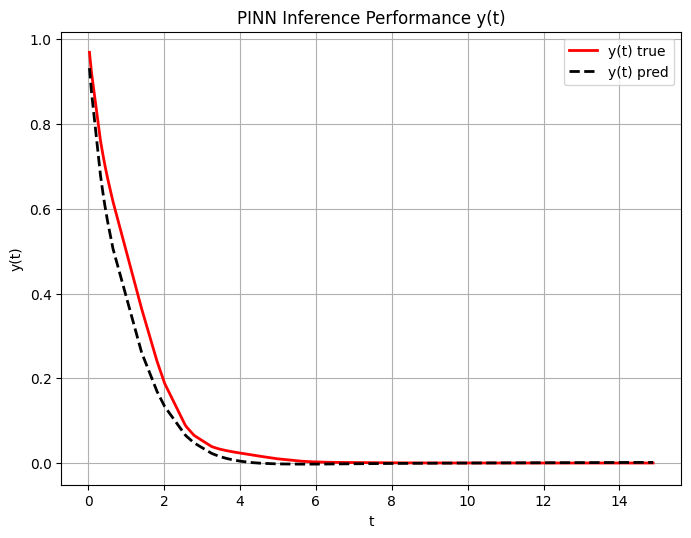

In [81]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(together[:,0],together[:,1], color="red", linewidth=2, label='y(t) true')
plt.plot(together1[:,0], together1[:,1],color="black",linestyle='--', linewidth=2, label='y(t) pred')
plt.legend()
plt.grid()
plt.xlabel("t")
plt.ylabel("y(t)")
plt.title("PINN Inference Performance y(t)")

In [82]:
together = np.hstack([t_f,de_f])
together = together[together[:, 0].argsort()]

together1 = np.hstack([t_f,de_pred])
together1 = together1[together1[:, 0].argsort()]

Text(0.5, 1.0, 'PINN Inference Performance f')

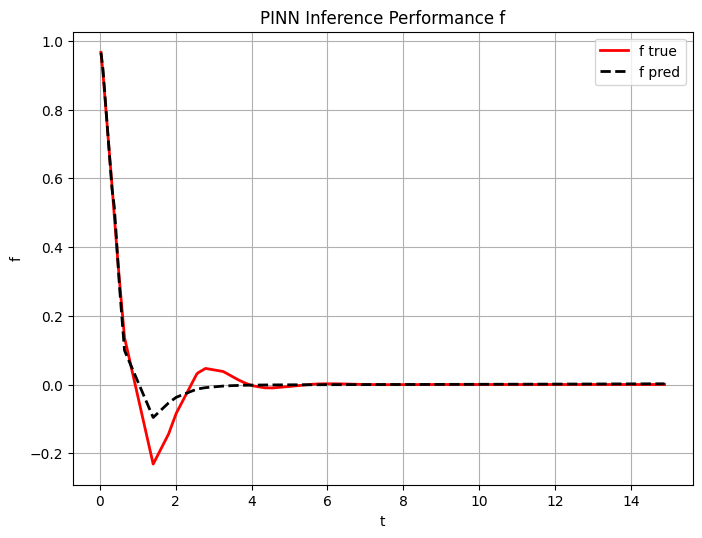

In [83]:
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(together[:,0],together[:,1], color="red", linewidth=2, label='f true')
plt.plot(together1[:,0],together1[:,1], color="black",linestyle='--', linewidth=2, label='f pred')
plt.legend()
plt.grid()
plt.xlabel("t")
plt.ylabel("f")
plt.title("PINN Inference Performance f")

In [84]:
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(t_eval, de_eval, color="red", linewidth=2, label='DE true')
plt.plot(t_eval,f_pred + np.exp(-t_eval)*np.cos(2*t_eval) , color="black",linestyle='--', linewidth=2, label='DE pred')
plt.legend()
plt.grid()
plt.xlabel("t")
plt.ylabel("DE")
plt.title("PINN Inference Performance DE")

NameError: name 't_eval' is not defined

<Figure size 800x600 with 0 Axes>